In [ ]:
%config Application.iopub_data_rate_limit=10000000 #for increasing the buffer limit to upload images


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from PIL import Image
from multiprocessing import Pool
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns

import cv2
from sklearn.utils import shuffle

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Group_Project_Data')
print(os.getcwd())

/content/drive/MyDrive/Group_Project_Data


# **Loading Dataset and Pre-processing**

In [ ]:


# Set the path to the parent directory that contains the subdirectories of images
path_to_images = '/content/drive/MyDrive/Group_Project_Data/Train'

# Set the batch size and image size
batch_size = 32
img_size = (64,64)

# Load the images using tf.keras.preprocessing.image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_images,
  validation_split=None,
  seed=123,
  image_size=img_size,
  batch_size=batch_size
)

Found 6000 files belonging to 2 classes.


In [ ]:
# Extract the images and labels from the train_ds dataset
images_labels_ds = train_ds.map(lambda x, y: (x, y))

# Iterate through the images and labels dataset and extract the images and labels
images = []
labels = []
for batch_images, batch_labels in images_labels_ds:
    batch_size = batch_images.shape[0]
    unstacked_images = tf.unstack(batch_images, num=batch_size)
    unstacked_labels = tf.unstack(batch_labels, num=batch_size)
    for image in unstacked_images:
        gray_image = tf.image.rgb_to_grayscale(image).numpy()
        images.append(gray_image)
    labels.extend([label.numpy() for label in unstacked_labels])

# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the images and labels arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (6000, 64, 64, 1)
Labels shape: (6000,)


In [ ]:
# Set the path to the parent directory that contains the subdirectories of images
path_to_images2 = '/content/drive/MyDrive/Group_Project_Data/Valid'

# Set the batch size and image size
batch_size = 32
img_size = (64,64)

# Load the images using tf.keras.preprocessing.image_dataset_from_directory
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_images2,
  validation_split=None,
  seed=123,
  image_size=img_size,
  batch_size=batch_size
)

Found 1999 files belonging to 2 classes.


In [ ]:
# Extract the images and labels from the valid_ds dataset
images_labels_ds2 = valid_ds.map(lambda x, y: (x, y))

# Iterate through the images and labels dataset and extract the images and labels
images2 = []
labels2 = []
for batch_images, batch_labels in images_labels_ds2:
    batch_size = batch_images.shape[0]
    unstacked_images2 = tf.unstack(batch_images, num=batch_size)
    unstacked_labels2 = tf.unstack(batch_labels, num=batch_size)
    for image in unstacked_images2:
        gray_image2 = tf.image.rgb_to_grayscale(image).numpy()
        images2.append(gray_image2)
    labels2.extend([label.numpy() for label in unstacked_labels2])

# Convert the images and labels to NumPy arrays
images2 = np.array(images2)
labels2 = np.array(labels2)

# Print the shapes of the images and labels arrays
print("Images shape:", images2.shape)
print("Labels shape:", labels2.shape)
print(labels2)

Images shape: (1999, 64, 64, 1)
Labels shape: (1999,)
[1 1 1 ... 1 0 0]


# **Model Creation**

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Recall(),keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # monitor validation loss
    patience=3,            # number of epochs with no improvement
    verbose=1,             # print messages when stopping
    restore_best_weights=True  # restore the best weights from the epoch with the lowest validation loss
)

# **Training**

In [ ]:
# Train the model with early stopping
history = model.fit(images,labels, epochs=20 , validation_data=(images2, labels2),callbacks=[early_stopping])

Epoch 1/20
188/188 [==============================] - 12s 11ms/step - loss: 0.1264 - binary_accuracy: 0.9703 - recall: 0.9773 - precision: 0.9638 - val_loss: 0.0190 - val_binary_accuracy: 0.9925 - val_recall: 0.9880 - val_precision: 0.9970
Epoch 2/20
188/188 [==============================] - 1s 8ms/step - loss: 0.0051 - binary_accuracy: 0.9982 - recall: 0.9977 - precision: 0.9987 - val_loss: 0.0173 - val_binary_accuracy: 0.9960 - val_recall: 0.9980 - val_precision: 0.9940
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.0101 - binary_accuracy: 0.9970 - recall: 0.9973 - precision: 0.9967 - val_loss: 0.0059 - val_binary_accuracy: 0.9970 - val_recall: 0.9980 - val_precision: 0.9960
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.0077 - binary_accuracy: 0.9982 - recall: 0.9977 - precision: 0.9987 - val_loss: 0.0088 - val_binary_accuracy: 0.9965 - val_recall: 0.9980 - val_precision: 0.9950
Epoch 5/20
188/188 [==========================

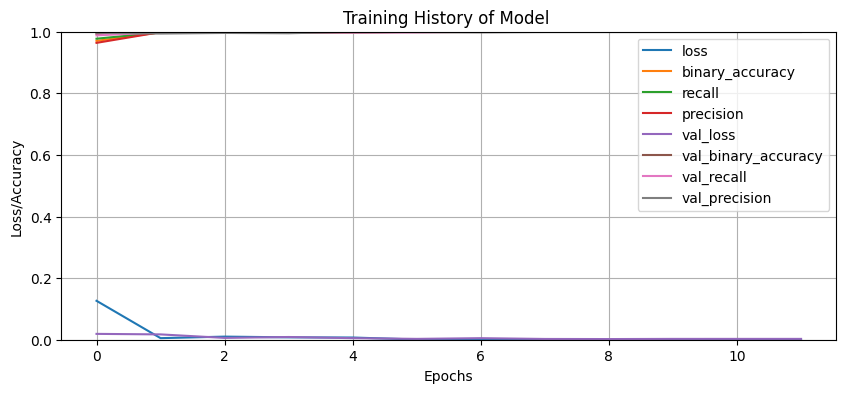

In [ ]:
plt.rcParams['figure.figsize']=(10,4)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.title('Training History of Model ')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.show()

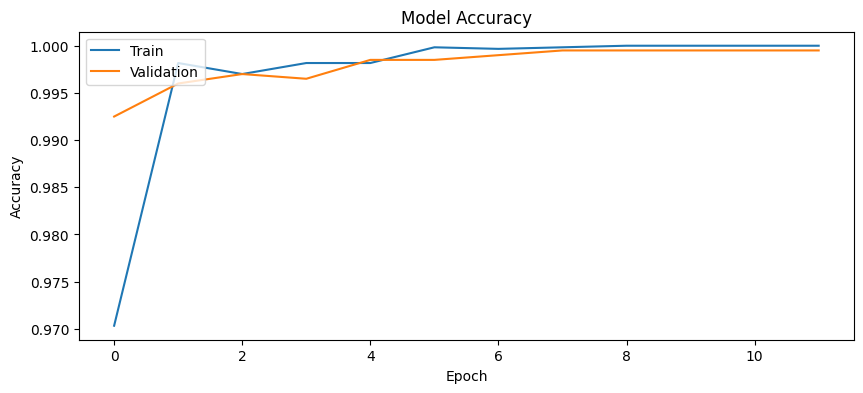

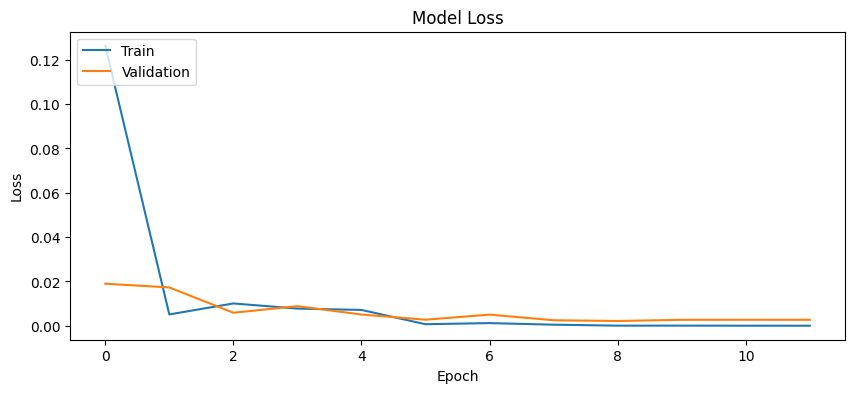

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Model Evaluation**

In [ ]:
U = model.predict(images2)

63/63 [==============================] - 0s 3ms/step


In [ ]:
y_pred_ = np.argmax(U, axis=1)

In [ ]:
labels2 = labels2.reshape((len(labels2), 1))

In [ ]:
y_true =  np.argmax(labels2, axis=1)
y_true

array([0, 0, 0, ..., 0, 0, 0])

correctly labelled
____________________________________________________________________________________________________________________________


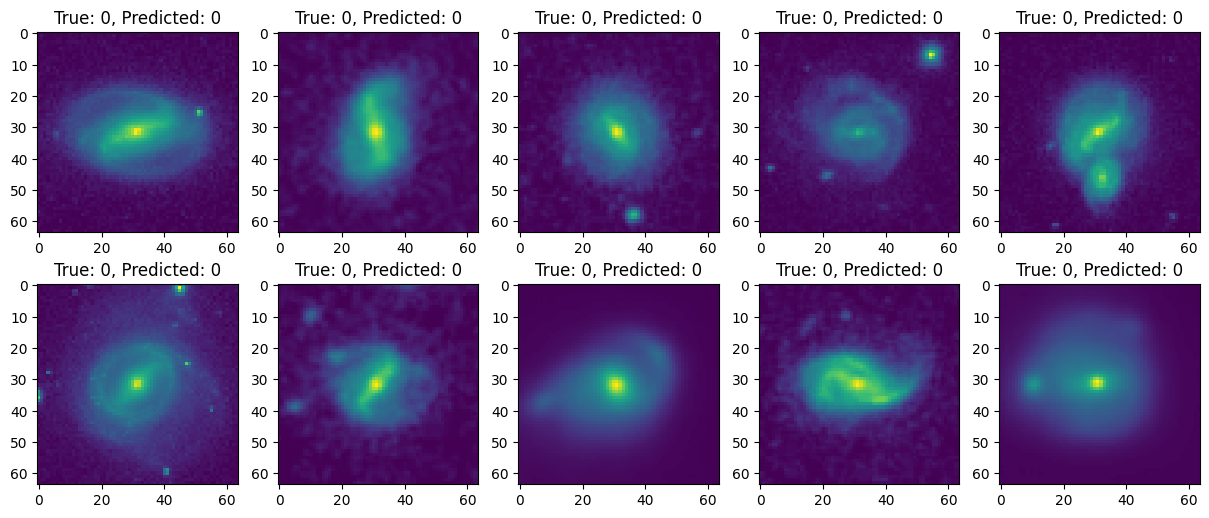

There are no misclassified images in the test set


In [ ]:
# Select correctly classified and misclassified indices for each class
correct_indices = np.where(y_pred_ == np.argmax(labels2))[0]
incorrect_indices = np.where(y_pred_ != np.argmax(labels2))[0]

print('correctly labelled')
print('____________________________________________________________________________________________________________________________')
fig, axes = plt.subplots(nrows=2, ncols=min(5, len(correct_indices)), figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(correct_indices):
        img_idx = correct_indices[i]
        ax.imshow(images2[img_idx])
        ax.set_title(f"True: {np.argmax(labels2[img_idx])}, Predicted: {y_pred_[img_idx]}")
    else:
        ax.axis('off')
plt.show()

if len(incorrect_indices) > 0:
    print('incorrectly labelled')
    print('____________________________________________________________________________________________________________________________')
    fig, axes = plt.subplots(nrows=1, ncols=len(incorrect_indices), figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        img_idx = incorrect_indices[i]
        ax.imshow(images2[img_idx])
        ax.set_title(f"True: {np.argmax(labels2[img_idx])}, Predicted: {y_pred_[img_idx]}")
    plt.show()
else:
    print('There are no misclassified images in the test set')


In [ ]:
print(classification_report( y_true,y_pred_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1999

    accuracy                           1.00      1999
   macro avg       1.00      1.00      1.00      1999
weighted avg       1.00      1.00      1.00      1999



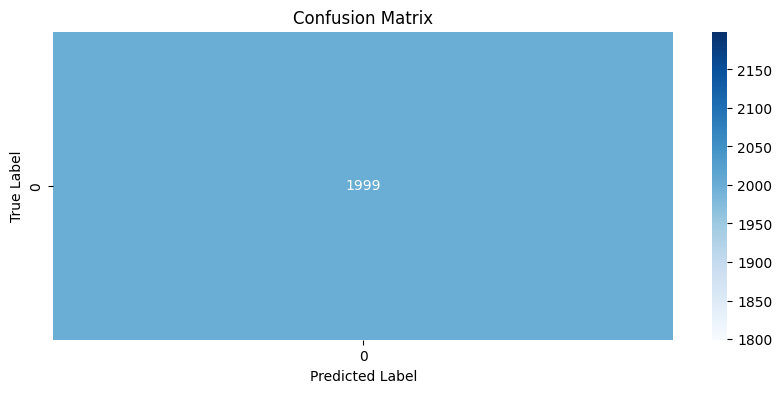

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Saving and Zipping of Model**

In [ ]:
# Saving your model

#our_model.save('/content/Group_X_Model_Trained')

# Create a directory to save the model if it doesn't exist
if not os.path.exists('Group_33_Model_Trained'):
    os.makedirs('Group_33_Model_Trained')

# Save the model in the "models" directory
model.save('/content/Group_33_Model_Trained/our_model.h5')

In [ ]:
# Test saved model

loaded_model = tf.keras.models.load_model('/content/Group_33_Model_Trained/our_model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0

In [ ]:
# zip the model
!zip -r /content/Group_33_Model_Trained/our_model.h5.zip /content/Group_33_Model_Trained/our_model.h5

  adding: content/Group_33_Model_Trained/our_model.h5 (deflated 21%)
